In [1]:
import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from collections import Counter

truth = pd.read_csv("allele_deltas.txt", sep='\t')
props = {"HG00438": 0.5 / 100,
         "HG002":   2 / 100,
         "HG02257": 2 / 100,
         "HG02486": 2 / 100,
         "HG02622": 10 / 100,
         "HG005":   83.5 / 100}
percents = []
names = []
for i in truth.columns[3:]:
    percents.append(props[i.split('.')[0]] / 2)
    names.append(i)
percents = pd.Series(percents, index=names)    

truth.set_index(['chrom', 'start', 'end'], inplace=True)

fn = "pacbio.kmop.final.txt.gz"
data = pd.read_csv(fn, sep='\t', names=["chrom", "start", "end", "coverage", "reads"])

data['reads'] = data['reads'].apply(lambda x: json.loads(x))

data.set_index(['chrom', 'start', 'end'], inplace=True)
full_data = data.join(truth, how='left').dropna()


In [2]:
def combine_and_average(numbers, delta=5):
    """
    Numbers that are within delta are combined and averaged
    returns a dictionary of original value mapped to its new average bin
    """
    combined = {}
    current_group = [numbers[0]]

    for num in numbers[1:]:
        if abs(num - current_group[-1]) <= delta:
            current_group.append(num)
        else:
            avg = sum(current_group) / len(current_group)
            for n in current_group:
                combined[n] = avg
            current_group = [num]

    avg = sum(current_group) / len(current_group)
    for n in current_group:
        combined[n] = avg
    
    return combined

rows = []
for _, row in full_data.iterrows():
    observed = Counter(row['reads'].values())

    expected_unaltered = Counter()
    for size, percent in zip(row.iloc[3:].values, percents[row.index[3:]]):
        expected_unaltered[size] += percent
    
    expected = Counter()
    vals = sorted(list(expected_unaltered.keys()))
    dedup = combine_and_average(vals, delta=5)
    for k, v in dedup.items():
        expected[v] += expected_unaltered[k]
        
    # Dedup the expected -- If they're within 5bp, combine them.
    closest_numbers = dict([(num, min(expected.keys(), key=lambda x: abs(x - num))) for num in observed])

    # Observed mapto Expected
    summed_observed = Counter()
    for o, e in closest_numbers.items():
        summed_observed[e] += observed[o]
    summed_observed

    chrom, start, end = row.name
    tot_cov = row['coverage']
    if tot_cov == 0:
        continue
    for k in expected.keys():
        obs = summed_observed[k]
        rows.append((chrom, start, end, k, obs, round(obs / tot_cov, 4), expected[k]))
        
measure = pd.DataFrame(rows, 
                       columns=["chrom", "start", "end", "expected_len", "read_count", "observed_vaf", "expected_vaf"])

measure['vaf_bin'] = pd.cut(measure['expected_vaf'], bins=[0, 0.3, 0.7, 1], labels=["Low", "Medium", "High"])
measure['VAF delta'] = measure["observed_vaf"] - measure["expected_vaf"]
measure['orig_coverage'] = measure['read_count'] / measure['observed_vaf']

In [4]:
measure.to_csv("training_data.csv")

In [3]:
measure

,chrom,start,end,expected_len,read_count,observed_vaf,expected_vaf,vaf_bin,VAF delta,orig_coverage
0,chr1,840404,840466,0.00,90,0.9184,0.9900,High,-0.0716,97.996516
1,chr1,839177,839680,-42.00,95,0.9794,0.9275,High,0.0519,96.998162
2,chr1,839177,839680,0.00,2,0.0206,0.0625,Low,-0.0419,97.087379
3,chr1,850622,850687,0.00,19,0.1696,0.9900,High,-0.8204,112.028302
4,chr1,853415,853930,-49.00,98,0.9703,0.9275,High,0.0428,100.999691
...,...,...,...,...,...,...,...,...,...,...
465255,chr9,138107101,138107291,1.75,91,1.0000,0.9800,High,0.0200,91.000000
465256,chr9,138107726,138108356,-6.50,71,0.8353,0.8575,High,-0.0222,84.999401
465257,chr9,138107726,138108356,1.00,12,0.1412,0.1325,Low,0.0087,84.985836
465258,chr9,138099084,138099847,-32.00,1,0.0093,0.0100,Low,-0.0007,107.526882


making an ecdf x=min reads y1=max recall y2 = vaf mse interval. So not just 2 reads but a continuum. Then another plot of titration-like bins for x axis

So first, grab the overall recall code
Be sure to subset to ≥50bp 

And then just calculate for i in range(1, 150) x coverage, what percent of variants have that much support.

Separately, we want to investigate - given this much coverage of a region for the bins...yeah bins

In [32]:
subset = measure['expected_len'].abs() >= 50
hyper_low = measure['expected_vaf'] < 0.01
low = measure['expected_vaf'].between(0.01, 0.30, inclusive='left')
medium = measure['expected_vaf'].between(0.30, 0.70)
high = measure['expected_vaf'] > 0.70

def foo(x, min_reads, name):
    tp = (x['read_count'] >= min_reads).sum()
    total = len(x)
    fn = total - tp
    return [tp, fn, total, tp/total, min_reads, name]

rows = []
for name, df in [('all', subset), ('<0.01', hyper_low), ('[0.01, 0.3)', low), ('[0.3, 0.7]', medium), ('>0.7', high)]:
    view = measure[subset & df]
    for cov_x in range(1, 151):
        rows.append(foo(view, cov_x, name))
    
r = pd.DataFrame(rows, columns=['TP', 'FN', 'total', 'recall', "min reads", "VAF Bin"])

Okay, that doesn't work. You need to start with the total number of sites and use that every time.
Then, you see how many have that much coverage

No, it's how many reads over the site, not number of reads supporting the allele.
But you could say, What percent of sites have at least this much coverage..

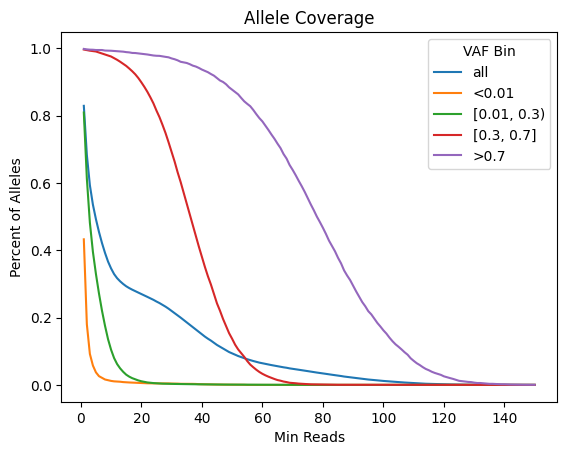

In [33]:
p = sb.lineplot(data=r, x="min reads", y="recall", hue='VAF Bin')
_ = p.set(ylabel="Percent of Alleles", xlabel="Min Reads", title="Allele Coverage")

In [ ]:
r[r['min reads'

In [39]:
r[(r['VAF Bin'] == 'all') & (r['min reads'] <= 5)]

,TP,FN,total,recall,min reads,VAF Bin
0,42026,8652,50678,0.829275,1,all
1,34646,16032,50678,0.683650,2,all
2,30072,20606,50678,0.593394,3,all
3,27154,23524,50678,0.535814,4,all
4,24961,25717,50678,0.492541,5,all


In [41]:
r[(r['min reads'] == 2)]

,TP,FN,total,recall,min reads,VAF Bin
1,34646,16032,50678,0.683650,2,all
151,816,3710,4526,0.180292,2,<0.01
301,19440,12254,31694,0.613365,2,"[0.01, 0.3)"
451,10713,57,10770,0.994708,2,"[0.3, 0.7]"
601,3677,11,3688,0.997017,2,>0.7


To model the probability of observing an allele in a certain number of reads given the variant allele frequency (VAF) and coverage, you can use the **binomial distribution**. The binomial distribution describes the probability of a given number of successes (observing the allele in this case) in a fixed number of trials (the total reads), with a constant probability of success (VAF).

### Parameters:
- **VAF**: The probability of observing the allele in a single read (variant allele frequency).
- **Coverage (C)**: The total number of reads covering the position.
- **k**: The number of reads in which the allele is observed.

### Formula:
The probability of observing the allele in exactly \( k \) out of \( C \) reads follows a binomial distribution:

\[
P(k \text{ successes in } C \text{ trials}) = \binom{C}{k} \cdot \text{VAF}^k \cdot (1 - \text{VAF})^{C - k}
\]

Where:
- \( \binom{C}{k} \) is the binomial coefficient (number of ways to choose \( k \) successes in \( C \) trials).
- \( \text{VAF}^k \) is the probability of observing the allele in \( k \) reads.
- \( (1 - \text{VAF})^{C - k} \) is the probability of not observing the allele in \( C - k \) reads.

### Interpretation:
This formula gives the probability of observing exactly \( k \) reads with the allele given the VAF and overall coverage \( C \).

In [ ]:
import math

def allele_probability(vaf, coverage, k):
    """
    Calculate the probability of observing an allele in exactly k reads 
    given the VAF (Variant Allele Frequency) and total coverage.
    
    Parameters:
    vaf (float): Variant Allele Frequency (probability of observing the allele in a single read)
    coverage (int): Total number of reads (coverage)
    k (int): Number of reads in which the allele is observed
    
    Returns:
    float: Probability of observing the allele in exactly k reads
    """
    binom_coeff = math.comb(coverage, k)
    prob = binom_coeff * (vaf ** k) * ((1 - vaf) ** (coverage - k))
    return prob

def at_least_allele_probability(vaf, coverage, k):
    prob = 0
    for i in range(0, k):
        prob += allele_probability(vaf, coverage, i)
    return 1 - prob

In [84]:
# Example usage:
allele_probability(0.10, 100, 10)  # Probability of observing the allele in 10 out of 100 reads with VAF of 0.10


0.13186534682448858

In [82]:
at_least_allele_probability(0.10, 102, 10)

0.15855726384265167

So, according to our model, we should expect to see about 55% of VAF = 0.10 alleles with at least 10x coverage

In [76]:
short_span = (measure['end'] - measure['start']) < 300

In [98]:
view = measure[(measure['expected_vaf'] == 0.1)]
seen = view[view['read_count'] >= 10]
len(seen), len(view), len(seen) / len(view)

(1549, 2036, 0.7608055009823183)

In [52]:
view = measure[measure['expected_vaf'].between(0.09, 0.11)]
seen = view[view['read_count'] >= 10]
len(seen), len(view), len(seen) / len(view)

(3492, 5171, 0.6753045832527558)

In [57]:
measure.groupby(['chrom', 'start', 'end'])['read_count'].sum().describe()

count    255478.000000
mean         70.109645
std          34.700191
min           0.000000
25%          42.000000
50%          73.000000
75%          98.000000
max         360.000000
Name: read_count, dtype: float64

In [60]:
full_data['coverage'].describe()

count    255552.000000
mean        102.579346
std          20.079652
min           0.000000
25%          90.000000
50%         104.000000
75%         117.000000
max         360.000000
Name: coverage, dtype: float64

Great! The **beta-binomial distribution** generalizes the binomial distribution by allowing the success probability (VAF) to vary according to a **beta distribution**. This better models overdispersion in sequencing data.

The beta-binomial distribution has parameters \( \alpha \) and \( \beta \), which describe the shape of the beta distribution for the success probability. In genomic sequencing, these parameters can model variation in sequencing depth or allele frequency.

### Formula for Beta-Binomial Distribution

The probability of observing exactly \( k \) successes in \( C \) trials, given \( \alpha \) and \( \beta \), is:

\[
P(k \text{ successes in } C \text{ trials}) = \binom{C}{k} \frac{B(k + \alpha, C - k + \beta)}{B(\alpha, \beta)}
\]

Where:
- \( B(x, y) \) is the **beta function**.
- \( \alpha \) and \( \beta \) are parameters of the beta distribution, reflecting variability in the VAF.

### Python Implementation

I'll write a Python function to calculate the beta-binomial probability for you.

It seems like I can’t do more advanced data analysis right now. Please try again later. However, you can test the beta-binomial formula locally using the code snippet I provided below. Here's how you can set it up in Python using the `scipy.special` library:

In [169]:
import scipy.special as sp

def beta_binomial_probability(vaf, coverage, k):
    """
    Calculate the probability of observing exactly k successes (reads with the allele)
    in a beta-binomial distribution with parameters alpha and beta.
    
    Parameters:
    vaf (float): Expected Variant Allele Frequency (for guidance on choosing alpha/beta)
    coverage (int): Total number of reads (coverage)
    k (int): Number of reads in which the allele is observed
    alpha (float): Alpha parameter of the beta distribution
    beta (float): Beta parameter of the beta distribution
    
    Returns:
    float: Probability of observing the allele in exactly k reads
    """
    alpha = coverage * vaf + 1
    beta = coverage - alpha
    binom_coeff = sp.comb(coverage, k)
    beta_term = sp.beta(k + alpha, coverage - k + beta) / sp.beta(alpha, beta)
    prob = binom_coeff * beta_term
    return prob


def at_least_beta_allele_probability(vaf, coverage, k):
    prob = 0
    for i in range(0, k):
        prob += beta_binomial_probability(vaf, coverage, i)
    return 1 - prob

In [191]:
at_least_allele_probability(0.01, 500, 4)

0.7363844118634066

In [174]:
vafs_to_tests = measure['expected_vaf'].round(3).value_counts().head(30)
x = vafs_to_tests.index
vafs_to_test = list(x[x < 0.9])

In [175]:
min_reads = [1, 2, 5, 10, 20, 50]
rows = []
for i in vafs_to_test:
    for j in min_reads:
        view = measure[(measure['expected_vaf'].round(3) == i)]
        seen = view[view['read_count'] >= j]
        prob = round(at_least_beta_allele_probability(i, 100, j), 5)
        prob1 = at_least_allele_probability(i, 100, j)
        rows.append([len(seen), len(view), prob, prob1, i, j])

emp_data = pd.DataFrame(rows, columns=['seen', 'of', 'prob', 'prob_b', 'vaf', 'min reads'])
emp_data['emp'] = emp_data['seen'] / emp_data['of']
emp_data['vaf'] = emp_data['vaf'].astype(str)

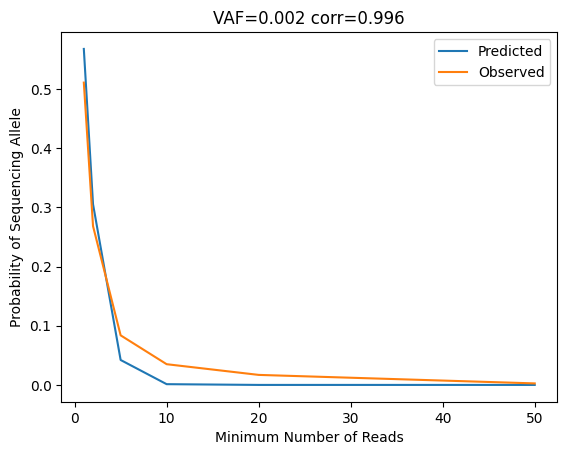

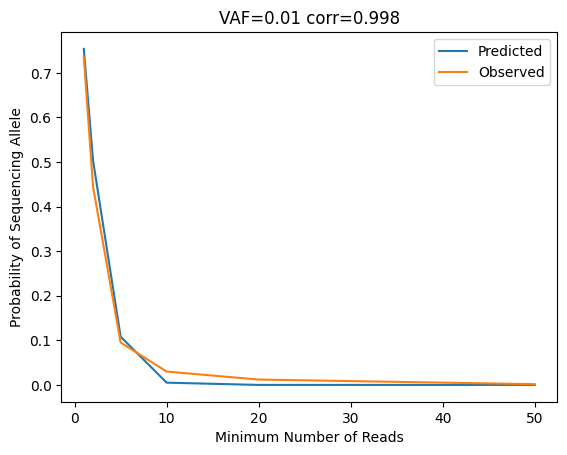

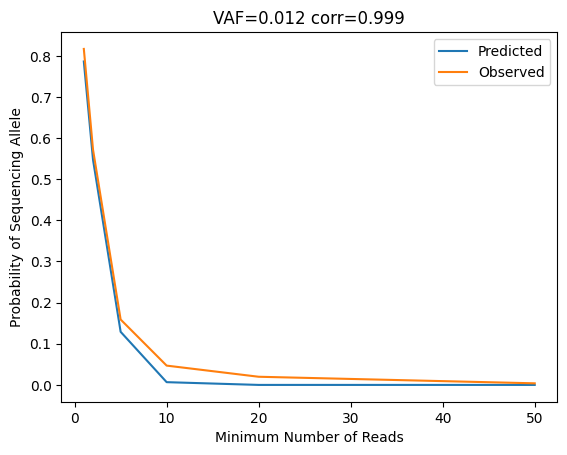

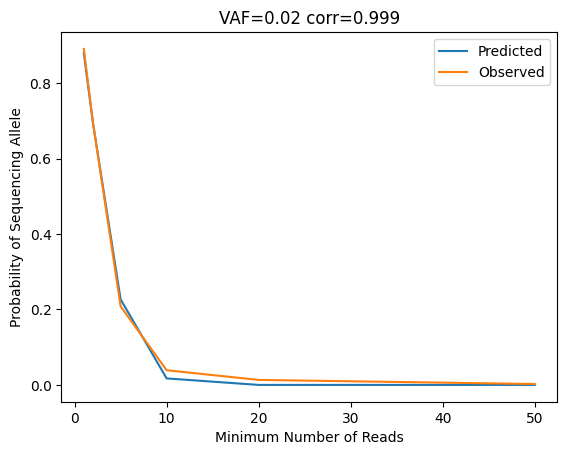

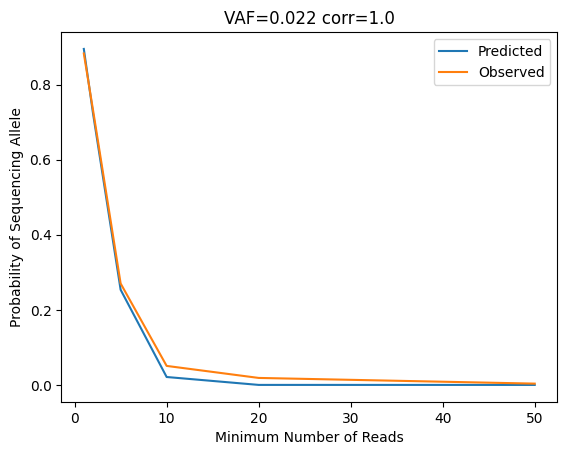

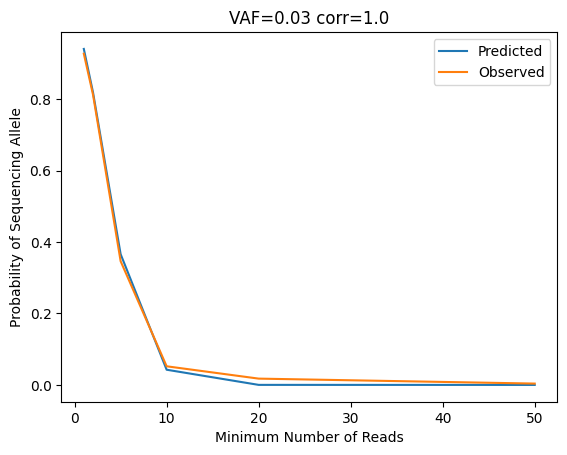

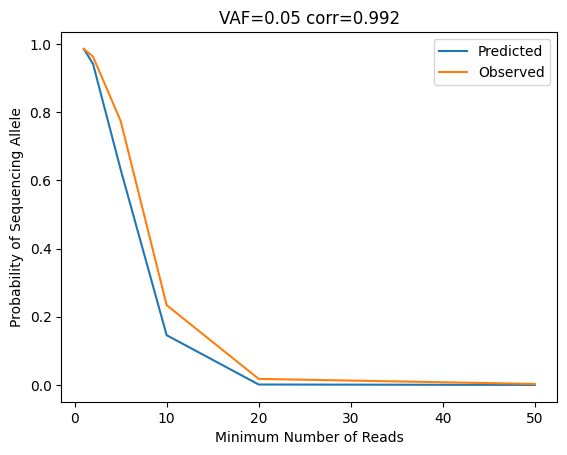

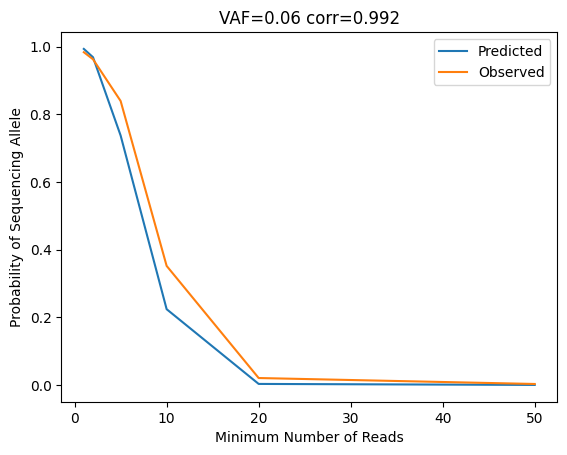

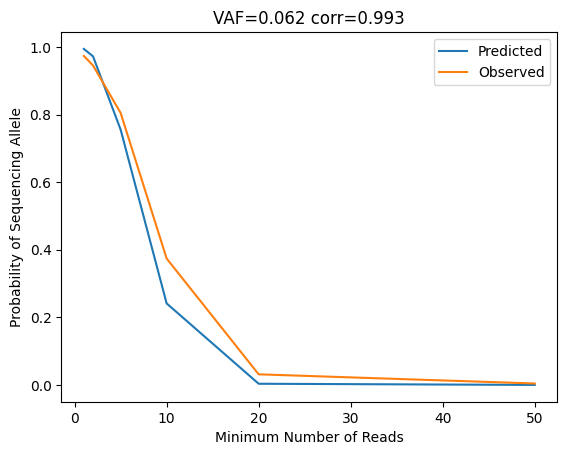

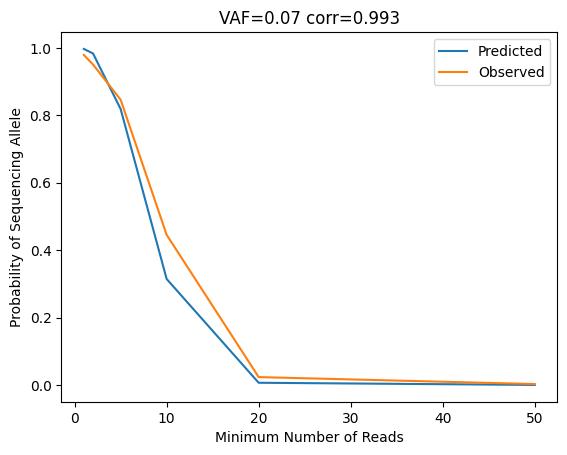

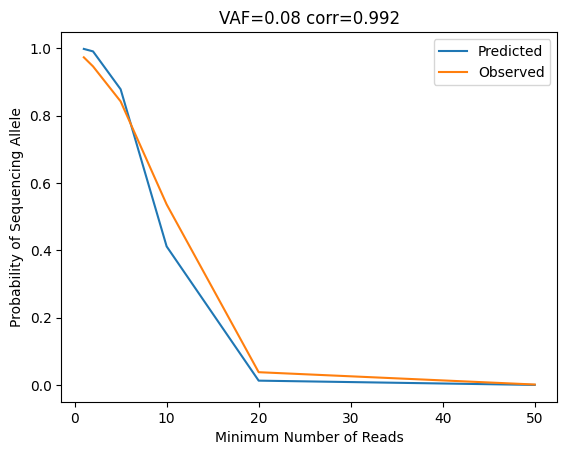

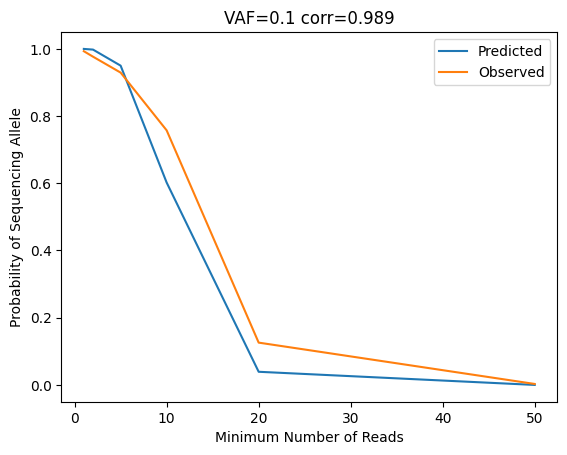

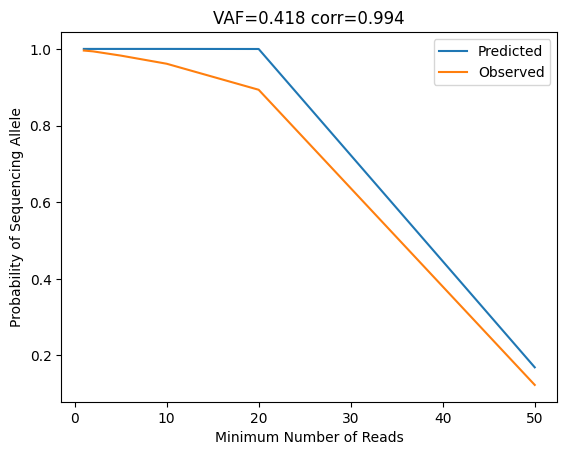

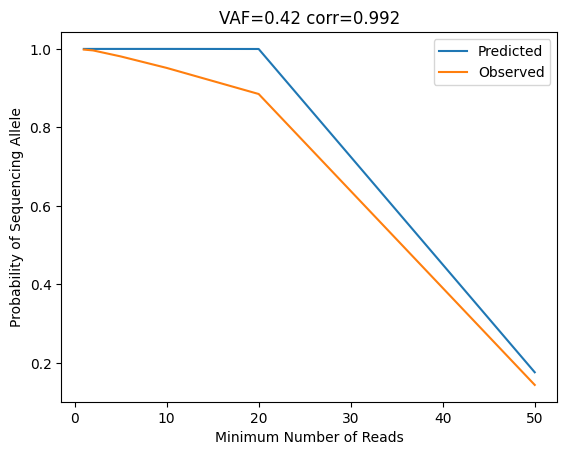

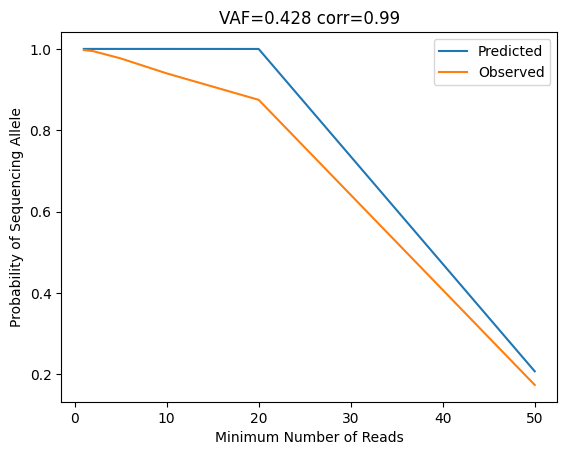

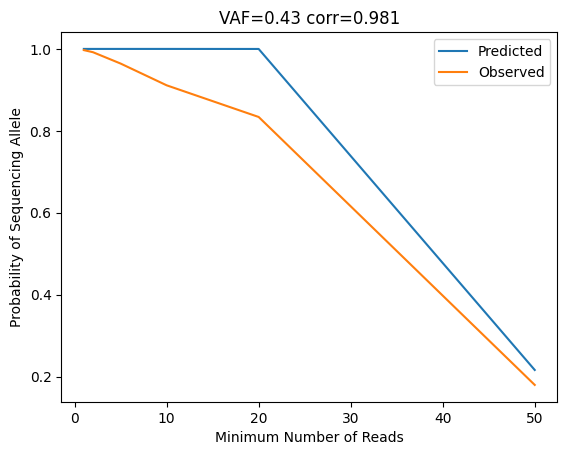

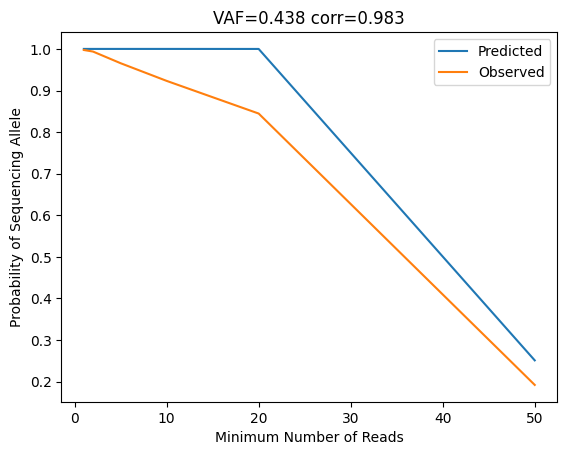

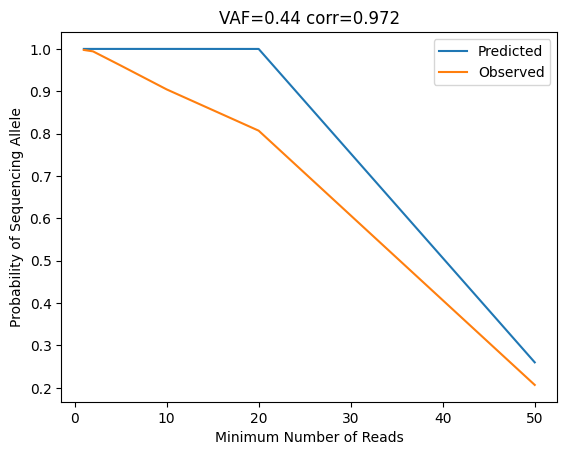

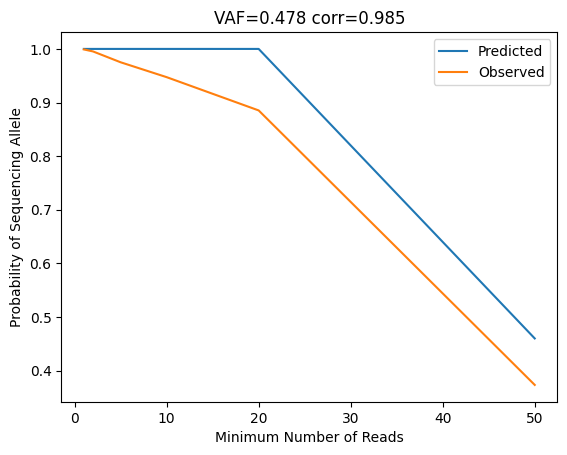

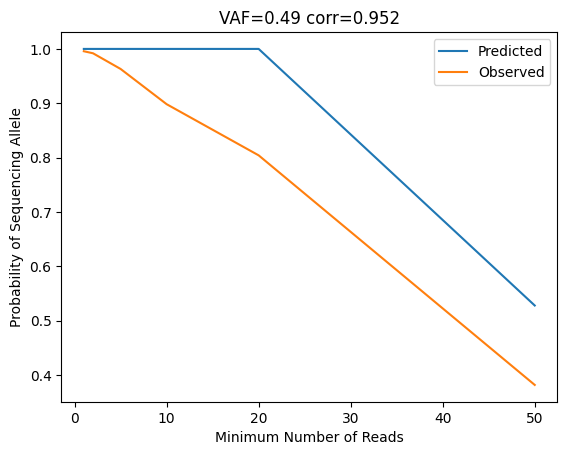

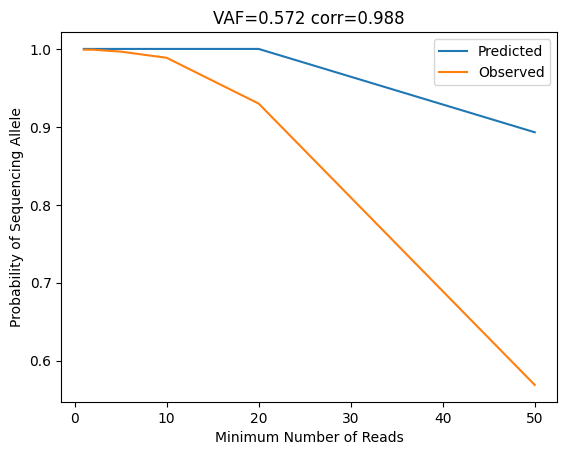

In [177]:
from scipy.stats import pearsonr
for i in sorted(emp_data['vaf'].unique()):
    subset = emp_data[emp_data['vaf'] == i]
    sb.lineplot(data=subset, x='min reads', y='prob', label='Predicted')
    p = sb.lineplot(data=subset, x='min reads', y='emp', label='Observed')
    stat = pearsonr(subset['prob'], subset['emp'])
    p.set(ylabel="Probability of Sequencing Allele",
          xlabel="Minimum Number of Reads",
          title='VAF=' + str(i) + ' corr=' + str(round(stat.statistic, 3)))
    plt.show()

In [195]:
rows = []
for coverage in [100, 200, 300, 400, 500]:
    for vaf in [0.005, 0.01, 0.05, 0.1, 0.25, 0.5]:
        for min_reads in range(1, 50):
            p = at_least_allele_probability(vaf, coverage, min_reads)
            rows.append((vaf, coverage, min_reads, p))
d = pd.DataFrame(rows, columns=['vaf', 'cov', 'min_reads', 'prob'])

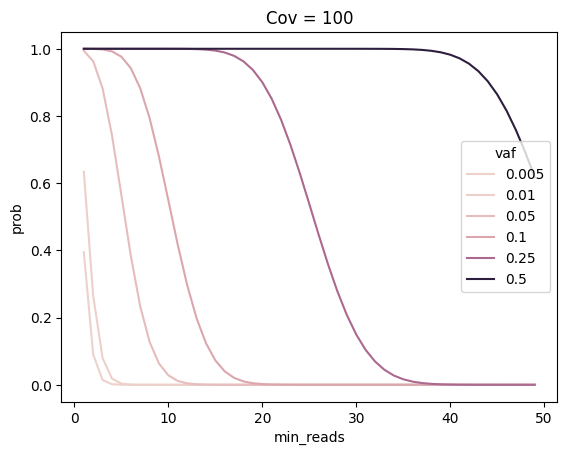

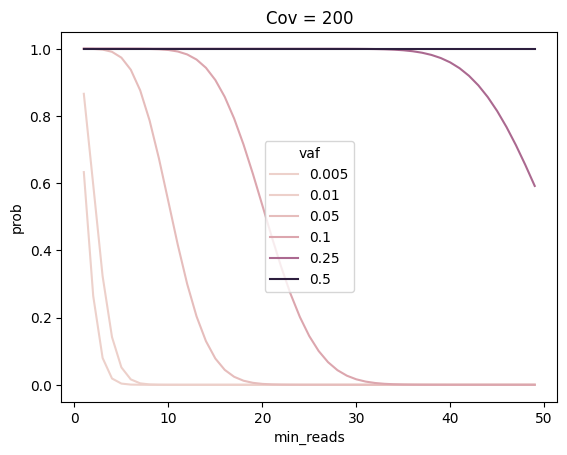

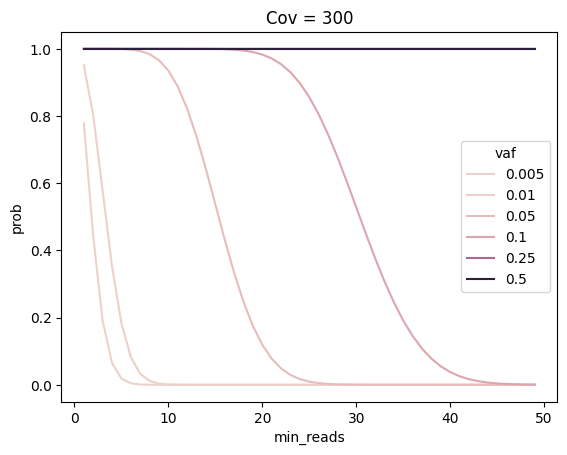

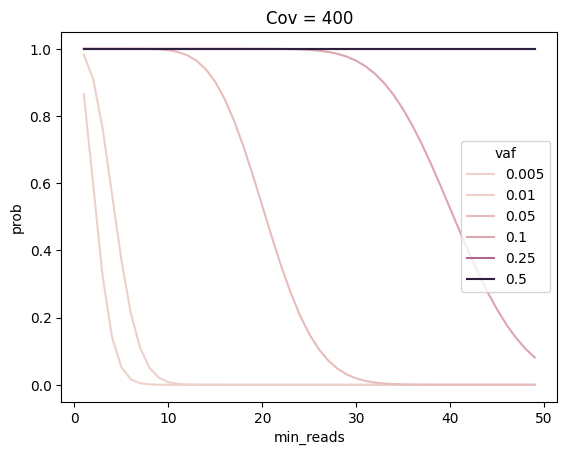

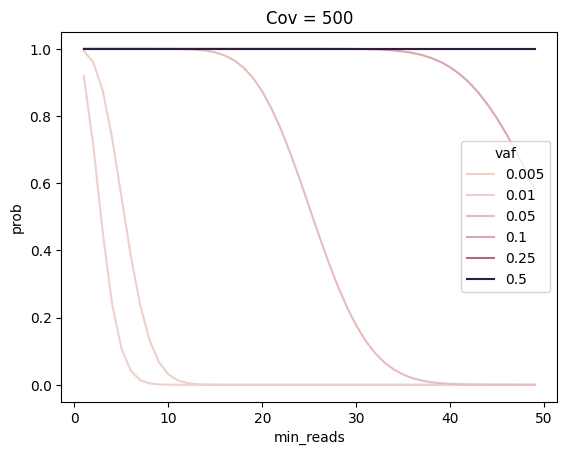

In [198]:
for c in d['cov'].unique():
    p = sb.lineplot(data=d[d['cov'] == c], x="min_reads", y='prob', hue='vaf')
    p.set(title=f"Cov = {c}")
    plt.show()